<a href="https://colab.research.google.com/github/zeligism/CubicOneShotSGD/blob/main/CubicOneShotSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data as data_utils
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

### Download datasets

In [ ]:
%%bash
# Download some regression datasets
DATASETS=("abalone" "bodyfat" "cpusmall" "housing" "mg" "mpg" "space_ga")
BASE_LINK="https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression"
for dataset in "${DATASETS[@]}"
    do [[ ! -f "${dataset}" ]] && wget -O "${dataset}" "${BASE_LINK}/${dataset}_scale"
done

In [ ]:
DATASET_FEATURES = {
    "abalone": 8,
    "bodyfat": 14,
    "cpusmall": 12,
    "housing": 13,
    "mg": 6,
    "mpg": 7,
    "space_ga": 6,
}

## Args

In [ ]:
class Args:
    def __init__(self):
        self.random_seed = 1
        self.num_workers = 2
        self.dataset = "space_ga"
        self.feature_dim = DATASET_FEATURES[self.dataset]
        self.output_dim = 1
        self.device = "cuda:0"

        # Mult model training
        self.num_models = 10
        self.agg_shots = 1
        self.T = 100
        self.val_freq = 10  # per grad computation

        # batch size and lr
        self.batch_size = 1
        self.base_lr = 5e-2
        self.lrs = [self.base_lr] * self.num_models

        # regularization
        self.reg_pow = None #2  # set to None if not needed
        self.reg_coeff = 1.0


args = Args()

In [ ]:
!echo "{args.dataset}:" && head "{args.dataset}"

space_ga:
-0.661559 1:0.00592061 2:-0.00797148 3:0.0708837 4:-0.121748 5:0.327746 6:-0.373847 
-0.650859 1:0.172948 2:0.164467 3:0.246374 4:0.0562393 5:0.288422 6:-0.533003 
-0.617114 1:-0.0390871 2:-0.095127 3:0.0167962 4:-0.219127 5:0.371988 6:-0.431117 
-0.63907 1:-0.119603 2:-0.196017 3:-0.0617125 4:-0.293841 5:0.310601 6:-0.335499 
-0.700274 1:0.0379821 2:-0.0147899 3:0.114062 4:-0.11785 5:0.330404 6:-0.252621 
-0.226367 1:-0.193244 2:-0.265719 3:-0.143932 4:-0.409506 5:0.360374 6:-0.410988 
-0.573181 1:-0.0600645 2:-0.114375 3:-0.00680918 4:-0.242633 5:0.326304 6:-0.440485 
-0.879874 1:0.254623 2:0.217428 3:0.293267 4:0.125499 5:0.356565 6:-0.269925 
-0.832006 1:0.0495964 2:-0.00583452 3:0.110378 4:-0.105459 5:0.371959 6:-0.342394 
-0.732962 1:-0.0784499 2:-0.142134 3:-0.0156008 4:-0.238071 5:0.364331 6:-0.235136 


## Dataset

In [ ]:
from sklearn.datasets import load_svmlight_file

class MyDataset(data_utils.Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        with open(self.dataset, "rb") as f:
            self.X, self.y = load_svmlight_file(f)

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        X_tensor = torch.Tensor(self.X[idx].todense()).squeeze(0)
        y_tensor = torch.Tensor([self.y[idx]]).squeeze(0)
        return X_tensor, y_tensor

class DataSampler:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.reset_sampler()

    def reset_sampler(self):
        self.sampler = iter(self.dataloader)

    def sample(self):
        try:
            x, y = next(self.sampler)
        except StopIteration:
            self.reset_sampler()
            x, y = next(self.sampler)
        return x, y

## Optimizer

In [ ]:
class LocalSGD(torch.optim.SGD):
    def aggregate(self, param_groups=None):
        if param_groups is None:
            param_groups = self.param_groups
        # This function simply averages parameters across all groups/models
        num_params = len(param_groups[0]["params"])
        agg_params = [None] * num_params
        # Find average per parameter
        for param_idx in range(num_params):
            param_list = [param_groups[model_idx]["params"][param_idx].data
                          for model_idx in range(len(param_groups))]
            agg_params[param_idx] = torch.mean(torch.stack(param_list, dim=0), dim=0)

        return agg_params

    def sync(self, agg_params, param_groups=None):
        if param_groups is None:
            param_groups = self.param_groups
        # Synchronize
        num_params = len(param_groups[0]["params"])
        for model_idx in range(len(param_groups)):
            for param_idx in range(num_params):
                param_groups[model_idx]["params"][param_idx] = agg_params[param_idx]

    def aggregate_and_sync(self):
        agg_params = self.aggregate()
        self.sync(agg_params)

### Aggregation Schedule

In [ ]:
# The schedule is just the iterations in which we aggregate
def n_shot_schedule(N, T):
    return {i for i in range(T-1, 0, -T // N)}

aggregation_idxs = n_shot_schedule(args.agg_shots, args.T)
aggregation_idxs

{99}

## Model

In [ ]:
def create_model():
    return nn.Linear(args.feature_dim, args.output_dim)

def init_model_(model):
    def init_weights(m):
        if isinstance(m, nn.Linear):
            # Use default initialization
            pass
    model.apply(init_weights)

def init_like_(m1, m2):
    with torch.no_grad():
        for p1, p2 in zip(m1.parameters(), m2.parameters()):
            p1.copy_(p2)

## Regularization

In [ ]:
def create_regularizer(p):
    assert p in (2, 3, 4)
    c = (0., 1., 1./2, 1./6, 1./24)
    def regularizer(model):
        params = nn.utils.parameters_to_vector(model.parameters())
        return torch.linalg.norm(params).pow(p) * c[p]
    return regularizer

# Training

### Progress Utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


### Data Utils

In [ ]:
def manual_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def create_seed_worker(seed):
    if seed is None:
        return None
    def seed_worker(worker_id):
        worker_seed = seed % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    return seed_worker

def create_generator(seed):
    if seed is None:
        return None
    g = torch.Generator()
    g.manual_seed(seed)
    return g

def create_trainloader(dataset, args):
    return data_utils.DataLoader(dataset, batch_size=args.batch_size,
                                 num_workers=args.num_workers, shuffle=True, pin_memory=True,
                                 worker_init_fn=create_seed_worker(args.random_seed),
                                 generator=create_generator(args.random_seed))
def create_testloader(dataset, args):
    return data_utils.DataLoader(dataset, batch_size=len(dataset),
                                 num_workers=args.num_workers, shuffle=False, pin_memory=True,
                                 worker_init_fn=create_seed_worker(args.random_seed),
                                 generator=create_generator(args.random_seed))


### Init

In [ ]:
# Set seed if given
if args.random_seed is not None:
    manual_seed(args.random_seed)

# Initialize dataset
"""
dataset = MyDataset(args.dataset)
test_len = int(args.test_size * len(dataset))
trainset, testset = data_utils.random_split(dataset, [len(dataset) - test_len, test_len])
"""
trainset = MyDataset(args.dataset)
testset = trainset  # test on full dataset

# Define a group of models (optimized in parallel) and a singled out model (optimized alone)
one_model = create_model().to(device=args.device)
one_optimizer = torch.optim.SGD(one_model.parameters(), lr=args.base_lr)
mult_models = [create_model().to(device=args.device) for i in range(args.num_models)]
param_groups = [{"params": mult_models[i].parameters(), "lr": args.lrs[i]} for i in range(args.num_models)]
mult_optimizer = LocalSGD(param_groups, lr=args.base_lr)

# Init models
init_model_(one_model)
for model in mult_models:
    init_like_(model, one_model)

# Loss function
loss_fn = nn.MSELoss().to(device=args.device)
regularizer = None
if args.reg_pow is not None:
    regularizer = create_regularizer(args.reg_pow)


### Train

In [ ]:
def validate(testloader, model):
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0
        for x, y in testloader:
            x = x.to(device=args.device)
            y = y.to(device=args.device)
            y_pred = model(x).view_as(y)
            loss = loss_fn(y_pred, y)
            acc = torch.sum(y_pred.round() == y) / y.size(0)
            running_loss += loss.item()
            running_acc += acc.item()
        mean_loss = running_loss / len(testloader)
        mean_acc = running_acc / len(testloader)
    return mean_loss, mean_acc

def train_models(T, trainloader, testloader, models, optimizer, loss_fn, regularizer):
    data_sampler = DataSampler(trainloader)
    stats = defaultdict(list)
    train_losses = AverageMeter("train_loss", ":.4f")
    val_losses = AverageMeter("val_loss", ":.4f")
    progress = ProgressMeter(T, [train_losses, val_losses])
    # Create dummy model for validating aggregated model
    agg_model = create_model().to(device=args.device)

    for t in range(T):
        # Validate
        if (t * len(models)) % args.val_freq == 0:
            with torch.no_grad():
                if len(models) > 1:
                    agg_params = optimizer.aggregate()
                    for p1, p2 in zip(agg_model.parameters(), agg_params):
                        p1.copy_(p2)
                    val_loss, _ = validate(testloader, agg_model)
                else:
                    val_loss, _ = validate(testloader, models[0])
            stats["val_loss"] += [val_loss]
            val_losses.update(val_loss)

        for model in models:
            x, y = data_sampler.sample()
            x = x.to(device=args.device)
            y = y.to(device=args.device)
            y_pred = model(x).view_as(y)
            loss = loss_fn(y_pred, y)
            if regularizer is not None:
                loss = loss + args.reg_coeff * regularizer(model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            stats["train_loss"] += [loss.item()]
            train_losses.update(loss.item())

        progress.display(t)

    return stats


print("Training single model...")
stats_one = train_models(args.T * args.num_models,
                         create_trainloader(trainset, args),
                         create_testloader(testset, args),
                         [one_model], one_optimizer, loss_fn, regularizer)
print("Training multiple models...")
stats_mult = train_models(args.T,
                          create_trainloader(trainset, args),
                          create_testloader(testset, args),
                          mult_models, mult_optimizer, loss_fn, regularizer)

stats = {
    "mult_train_loss": stats_mult["train_loss"],
    "mult_val_loss": stats_mult["val_loss"],
    "one_train_loss": stats_one["train_loss"],
    "one_val_loss": stats_one["val_loss"],
}

Training single model...
[   0/1000]	train_loss 0.1474 (0.1474)	val_loss 0.2261 (0.2261)
[   1/1000]	train_loss 0.0728 (0.1101)	val_loss 0.2261 (0.2261)
[   2/1000]	train_loss 0.0369 (0.0857)	val_loss 0.2261 (0.2261)
[   3/1000]	train_loss 0.0970 (0.0885)	val_loss 0.2261 (0.2261)
[   4/1000]	train_loss 0.0028 (0.0714)	val_loss 0.2261 (0.2261)
[   5/1000]	train_loss 0.0223 (0.0632)	val_loss 0.2261 (0.2261)
[   6/1000]	train_loss 0.3503 (0.1042)	val_loss 0.2261 (0.2261)
[   7/1000]	train_loss 0.0347 (0.0955)	val_loss 0.2261 (0.2261)
[   8/1000]	train_loss 0.0878 (0.0947)	val_loss 0.2261 (0.2261)
[   9/1000]	train_loss 0.0721 (0.0924)	val_loss 0.2261 (0.2261)
[  10/1000]	train_loss 0.1344 (0.0962)	val_loss 0.0663 (0.1462)
[  11/1000]	train_loss 0.0052 (0.0887)	val_loss 0.0663 (0.1462)
[  12/1000]	train_loss 0.0426 (0.0851)	val_loss 0.0663 (0.1462)
[  13/1000]	train_loss 0.0252 (0.0808)	val_loss 0.0663 (0.1462)
[  14/1000]	train_loss 0.1305 (0.0841)	val_loss 0.0663 (0.1462)
[  15/1000]	tra

# Results

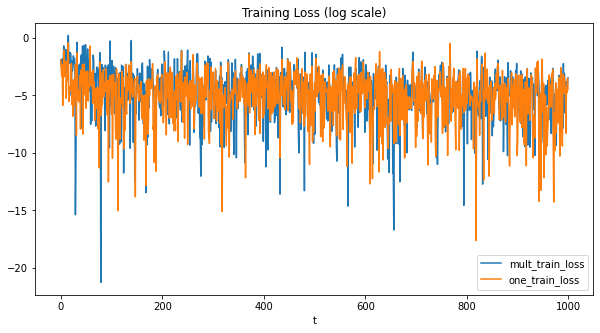

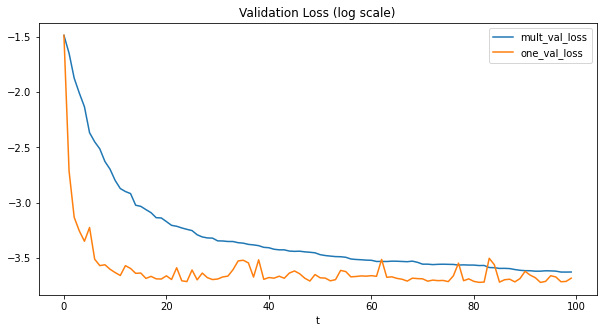

In [ ]:
from math import log
log_scale = True

def plot_lines(losses_dict, title="", filename=None, ):
    plt.figure(figsize=(10,5))
    plt.title(title)
    for label, losses in losses_dict.items():
        plt.plot(losses, label=label)
    plt.xlabel("t")
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    plt.close()

apply_log = lambda v: list(map(log, v))
train_losses = {k: apply_log(v) if log_scale else v for k, v in stats.items() if "train_loss" in k}
val_losses = {k: apply_log(v) if log_scale else v for k, v in stats.items() if "val_loss" in k}
plot_lines(train_losses, "Training Loss" + (" (log scale)" if log_scale else ""))
plot_lines(val_losses, "Validation Loss" + (" (log scale)" if log_scale else ""))